In [42]:
# Reference : 
# https://richliao.github.io/supervised/classification/2016/11/26/textclassifier-convolutional/

import sys
import os

# os.environ['THEANO_FLAGS'] = "device=cuda*"
os.environ['KERAS_BACKEND']='tensorflow'
# os.environ['MKL_THREADING_LAYER']='GNU'

import numpy as np
import pandas as pd
from collections import defaultdict
import re

In [43]:
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
# Merge
from keras.models import Model

from keras import backend as K
from keras.engine.topology import Layer, InputSpec
# from keras import initializations
from keras import initializers
from keras import regularizers
from keras import optimizers
from keras import constraints

In [44]:
MAX_SENT_LENGTH = 100
MAX_SENTS = 15
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

## IMDB load

In [45]:
import pickle

def save_pickle(path, X):
    with open(path, 'wb') as f:
        pickle.dump(X, f)

def open_pickle(path):
    with open(path, 'rb') as f:
        X = pickle.load(f)
    return X

X_train = open_pickle("../../data/imdb/imdb_original_preprocessed_xtrain.pickle")
X_test = open_pickle("../../data/imdb/imdb_original_preprocessed_xtest.pickle")
y_train = open_pickle("../../data/imdb/imdb_original_preprocessed_ytrain.pickle")
y_test = open_pickle("../../data/imdb/imdb_original_preprocessed_ytest.pickle")

## Yelp Load

In [5]:
import gzip

def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)
        
def extract(path, key):
    corpus = []
    y = []
    text = parse(path)
    for l in text:
        corpus.append(l[key])
        y.append(l['overall'])
    return corpus, y

path = r"..\..\data\reviews_Amazon_Instant_Video_5.json.gz"
X, y = extract(path, 'reviewText')

y_norm = []

for target in y:
    if target>2.5:
        y_norm.append(1)
    else:
        y_norm.append(0)
        
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_norm, test_size=0.33, random_state=42)

C:\Users\Anneke\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [46]:
from nltk import tokenize
from textblob import TextBlob

In [47]:
reviews = [] #sentences
for i in range(len(X_train)):
    sentences = TextBlob(X_train[i]).raw_sentences
    reviews.append(sentences)

In [48]:
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_train)

C:\Users\Anneke\Anaconda3\lib\site-packages\keras_preprocessing\text.py:174: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [49]:
data = np.zeros((len(X_train), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')

In [50]:
for i, sentences in enumerate(reviews):
    for j, sent in enumerate(sentences):
        if j<MAX_SENTS:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                if k<MAX_SENT_LENGTH and tokenizer.word_index[word]<MAX_NB_WORDS:
                    data[i,j,k] = tokenizer.word_index[word]
                    k=k+1


In [51]:
word_index = tokenizer.word_index

In [52]:
labels = to_categorical(np.asarray(y_train))
labels = np.asarray(y_train)

In [53]:
print('Total %s unique tokens.' % len(word_index))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Total 85439 unique tokens.
Shape of data tensor: (25000, 15, 100)
Shape of label tensor: (25000,)


In [54]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

In [55]:
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [56]:
print('Number of positive and negative reviews in training and validation set')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))

Number of positive and negative reviews in training and validation set
10066
2434


In [57]:
GLOVE_DIR = "../../data/glove.6B"
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), 'rb')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [58]:
print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [59]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    
embedding_layer = Embedding(len(word_index)+1,
                               EMBEDDING_DIM,
                               weights=[embedding_matrix],
                               input_length=MAX_SENT_LENGTH,
                               trainable=True)

sentence_input = Input(shape=(MAX_SENT_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
sentEncoder = Model(sentence_input, l_lstm)

In [60]:
review_input = Input(shape=(MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')
review_encoder = TimeDistributed(sentEncoder)(review_input)
l_lstm_sent = Bidirectional(LSTM(100))(review_encoder)

In [61]:
preds = Dense(1, activation='sigmoid')(l_lstm_sent)
model = Model(review_input, preds)

In [62]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [63]:
print("model fitting - Hierarchical LSTM")
print(model.summary())

model fitting - Hierarchical LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 15, 100)           0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 200)           8704800   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 201       
Total params: 8,945,801
Trainable params: 8,945,801
Non-trainable params: 0
_________________________________________________________________
None


In [64]:
class AttLayer(Layer):
    def __init__(self, **kwargs):
        self.init = initializers.get('normal')
        super(AttLayer, self).__init__(**kwargs)
            
    def build(self, input_shape):
        assert len(input_shape)==3
        self.W = self.init((input_shape[-1],))
        self.trainable_weights = [self.W]
        super(AttLayer, self).build(input_shape)
        
    def call(self, x, mask=None):
        # u_{it}
        eij = K.tanh(K.dot(x, self.W))

        # alpha
        ai = K.exp(eij)
        weights = ai/K.sum(ai,axis=1).dimshuffle(0,'x')
        
        # s_i
        weighted_input = x * weights.dimshuffle(0,1, 'x')
        return weighted_input.sum(axis=1)
    
    def get_output_shape_for(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [65]:
# https://gist.github.com/cbaziotis/7ef97ccf71cbc14366835198c09809d2
# other reference : 
# https://gist.github.com/cbaziotis/6428df359af27d58078ca5ed9792bd6d

def dot_product(x, kernel):
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    
class AttentionWithContext(Layer):
    def __init__(self,
        W_regularizer=None, u_regularizer=None, b_regularizer=None,
        W_constraint=None, u_constraint=None, b_constraint=None,
        bias=True, **kwargs):
            
        self.supports_masking = False
        self.init = initializers.get('normal')
            
        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
            
        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)
    
        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                initializer=self.init,
                                name='{}_W'.format(self.name),
                                regularizer=self.W_regularizer,
                                constraint=self.W_constraint)
            
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                    initializer='zero',
                                    name='{}_b'.format(self.name),
                                    regularizer=self.b_regularizer,
                                    constraint=self.b_constraint)
            
        self.u = self.add_weight((input_shape[-1],),
                                initializer=self.init,
                                name='{}_u'.format(self.name),
                                regularizer=self.u_regularizer,
                                constraint=self.u_constraint)
    
        super(AttentionWithContext, self).build(input_shape)
    
    def compute_mask(self, input, input_mask=None):
        return None
        
    def call(self, x, mask=None):
        uit = dot_product(x, self.W)
            
        if self.bias:
            uit += self.b
                
        uit = K.tanh(uit)
#         ait = K.dot(uit, self.u) # only works on  
        
        ait = dot_product(uit, self.u)
        a = K.exp(ait)
        
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
            
        a = K.expand_dims(a)
        weighted_input = x * a
            
        return K.sum(weighted_input,axis=1)
        
    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [66]:
sentence_input = Input(shape=(MAX_SENT_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)

l_gru = Bidirectional(GRU(50, return_sequences=True))(embedded_sequences)
l_dense = TimeDistributed(Dense(10))(l_gru)
l_att = AttentionWithContext()(l_dense)

sentEncoder = Model(sentence_input, l_att)

review_input = Input(shape=(MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')
review_encoder = TimeDistributed(sentEncoder)(review_input)

l_gru_sent = Bidirectional(GRU(50, return_sequences=True))(review_encoder)
l_dense_sent = TimeDistributed(Dense(10))(l_gru_sent)
l_att_sent = AttentionWithContext()(l_dense_sent)

preds = Dense(1, activation='sigmoid')(l_att_sent)
model = Model(review_input, preds)

In [67]:
model.compile(loss='binary_crossentropy',
            optimizer='rmsprop',
            metrics=['acc'])


In [68]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 15, 100)           0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 15, 10)            8590430   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 15, 100)           18300     
_________________________________________________________________
time_distributed_8 (TimeDist (None, 15, 10)            1010      
_________________________________________________________________
attention_with_context_4 (At (None, 10)                120       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 8,609,871
Trainable params: 8,609,871
Non-trainable params: 0
_________________________________________________________________


In [69]:
print('model fitting - Hierarchical attention network')
history_imdb = model.fit(x_train, y_train, validation_data=(x_val, y_val),
           epochs=50, batch_size=32, verbose=1)

model fitting - Hierarchical attention network
Train on 20000 samples, validate on 5000 samples
Epoch 1/50
20000/20000 [==============================] - 413s 21ms/step - loss: 0.6843 - acc: 0.5331 - val_loss: 0.5267 - val_acc: 0.7670
Epoch 2/50
20000/20000 [==============================] - 411s 21ms/step - loss: 0.4193 - acc: 0.8065 - val_loss: 0.3376 - val_acc: 0.8556
Epoch 3/50
20000/20000 [==============================] - 409s 20ms/step - loss: 0.2843 - acc: 0.8810 - val_loss: 0.2676 - val_acc: 0.8878
Epoch 4/50
20000/20000 [==============================] - 410s 20ms/step - loss: 0.2256 - acc: 0.9131 - val_loss: 0.2665 - val_acc: 0.8862
Epoch 5/50
20000/20000 [==============================] - 407s 20ms/step - loss: 0.1889 - acc: 0.9287 - val_loss: 0.2781 - val_acc: 0.8942
Epoch 6/50
20000/20000 [==============================] - 410s 20ms/step - loss: 0.1569 - acc: 0.9398 - val_loss: 0.2696 - val_acc: 0.9010
Epoch 7/50
20000/20000 [==============================] - 409s 20ms/st

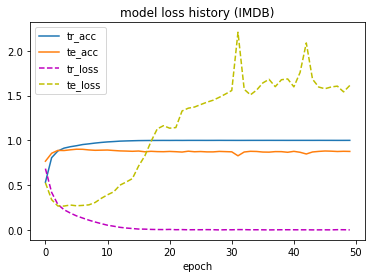

In [70]:
import matplotlib.pyplot as plt

plt.plot(history_imdb.history['acc'])
plt.plot(history_imdb.history['val_acc'])
plt.plot(history_imdb.history['loss'], 'm--')
plt.plot(history_imdb.history['val_loss'], 'y--')
plt.title('model loss history (IMDB)')
plt.xlabel('epoch')
plt.legend(['tr_acc', 'te_acc','tr_loss', 'te_loss'], loc='upper left')
plt.show()
plt.clf()

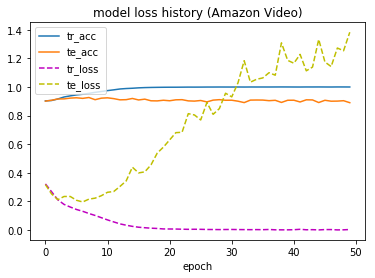

In [71]:
import matplotlib.pyplot as plt

plt.plot(history_amazon_video.history['acc'])
plt.plot(history_amazon_video.history['val_acc'])
plt.plot(history_amazon_video.history['loss'], 'm--')
plt.plot(history_amazon_video.history['val_loss'], 'y--')
plt.title('model loss history (Amazon Video)')
plt.xlabel('epoch')
plt.legend(['tr_acc', 'te_acc','tr_loss', 'te_loss'], loc='upper left')
plt.show()
plt.clf()

### Relevance sentence Model

In [178]:
# Preprocess
# path = r"C:\Users\Anneke\Documents\GitHub\data\imdb-sentence"
path = r"C:\Users\Anneke Hidayat\Documents\GitHub\data\imdb-sentence"
X_train_sent = open_pickle(path + r"\imdb_sentence_xtrain.pickle")
X_test_sent = open_pickle(path + r"\imdb_sentence_xtest.pickle")
y_train_sent = open_pickle(path + r"\imdb_sentence_ytrain.pickle")
y_test_sent = open_pickle(path + r"\imdb_sentence_ytest.pickle")

In [179]:
MAX_SEQUENCE = 20

In [180]:
data = np.zeros((len(X_train_sent), MAX_SEQUENCE), dtype='int32')

In [190]:
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_train_sent)
word_index = tokenizer.word_index

C:\Users\Anneke Hidayat\Anaconda3\lib\site-packages\keras_preprocessing\text.py:174: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [191]:
for i, doc in enumerate(X_train_sent):
    wordTokens = text_to_word_sequence(doc)
    for j, word in enumerate(wordTokens):
        try:
            if j<MAX_SEQUENCE and tokenizer.word_index[word]<MAX_NB_WORDS:
                data[i,j] = tokenizer.word_index[word]
        except KeyError as error:
            continue

In [192]:
test_data = np.zeros((len(X_test_sent), MAX_SEQUENCE), dtype='int32')
for i, doc in enumerate(X_test_sent):
    wordTokens = text_to_word_sequence(doc)
    for j, word in enumerate(wordTokens):
        try:
            if j<MAX_SEQUENCE and tokenizer.word_index[word]<MAX_NB_WORDS:
                test_data[i,j] = tokenizer.word_index[word]
        except KeyError as error:
            continue

In [193]:
test_data.shape

(667, 20)

In [194]:
data[0]

array([ 83, 460,   1, 952,   4,   1, 461, 555,  19, 102,  19, 349,   0,
         0,   0,   0,   0,   0,   0,   0])

In [195]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
y = y_train_sent[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

In [196]:
x_train = data[:-nb_validation_samples]
y_train = y[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = y[-nb_validation_samples:]

In [216]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index)+1,
                               EMBEDDING_DIM,
                               weights=[embedding_matrix],
                               input_length=MAX_SEQUENCE,
                               trainable=True)

In [72]:
sentence_input = Input(shape=(MAX_SEQUENCE,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
# embedded_sequences = embedding_layer()
sentence_gru = Bidirectional(GRU(50, return_sequences=True))(embedded_sequences)
sentence_dense = TimeDistributed(Dense(20))(sentence_gru) # 10
sentence_att = AttentionWithContext()(sentence_dense)
base_model = Model(embedded_sequences, sentence_att)

# output = Dense(1, activation='sigmoid')(base_model)

# model = base_model(output)

NameError: name 'MAX_SEQUENCE' is not defined

In [218]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 20)                0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 20, 100)           453300    
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 20, 100)           45300     
_________________________________________________________________
time_distributed_12 (TimeDis (None, 20, 20)            2020      
_________________________________________________________________
attention_with_context_10 (A (None, 20)                440       
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 21        
Total params: 501,081
Trainable params: 501,081
Non-trainable params: 0
_________________________________________________________________


In [219]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [220]:
print('model fitting - Hierarchical attention network')
model.fit(x_train, y_train, validation_data=(x_val, y_val),
           epochs=50, batch_size=32, verbose=1)

model fitting - Hierarchical attention network
Train on 1067 samples, validate on 266 samples
Epoch 1/50
1067/1067 [==============================] - 4s 3ms/step - loss: 0.7062 - acc: 0.5108 - val_loss: 0.7187 - val_acc: 0.5000
Epoch 2/50
1067/1067 [==============================] - 1s 1ms/step - loss: 0.6897 - acc: 0.5717 - val_loss: 0.6906 - val_acc: 0.5075
Epoch 3/50
1067/1067 [==============================] - 1s 1ms/step - loss: 0.6714 - acc: 0.5764 - val_loss: 0.6695 - val_acc: 0.5526
Epoch 4/50
1067/1067 [==============================] - 1s 1ms/step - loss: 0.6263 - acc: 0.6729 - val_loss: 0.6374 - val_acc: 0.6316
Epoch 5/50
1067/1067 [==============================] - 1s 1ms/step - loss: 0.4933 - acc: 0.7704 - val_loss: 0.5621 - val_acc: 0.7331
Epoch 6/50
1067/1067 [==============================] - 1s 1ms/step - loss: 0.3421 - acc: 0.8585 - val_loss: 0.6049 - val_acc: 0.7256
Epoch 7/50
1067/1067 [==============================] - 1s 1ms/step - loss: 0.2594 - acc: 0.8857 - val

In [44]:
sentence_input = Input(shape=(MAX_SEQUENCE,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
sentence_gru = Bidirectional(GRU(50, return_sequences=False))(embedded_sequences)
# sentence_dense = TimeDistributed(Dense(10))(sentence_gru)
# sentence_att = AttentionWithContext()(sentence_dense)
sentence_dense = Dense(10)(sentence_gru)

output = Dense(1, activation='sigmoid')(sentence_dense)
baseline = Model(sentence_input, output)

In [ ]:
baseline.summary()

In [ ]:
baseline.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
baseline.fit(x_train, y_train, validation_data=(x_val, y_val),
           epochs=10, batch_size=32, verbose=1)

In [221]:
get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[4].output])
layer_output = get_3rd_layer_output([x_train])[0]

In [222]:
layer_output[0]

array([-2.4435644 , -3.2460752 ,  1.5075619 , -2.5178852 ,  1.3407952 ,
        0.50468725,  2.0410352 , -0.5291209 ,  1.5506485 ,  0.73354095,
        1.3296204 ,  1.3797984 ,  1.8990283 , -2.478027  ,  0.41687998,
        1.8729966 , -1.4615527 , -2.8485737 ,  1.638824  ,  2.6011367 ],
      dtype=float32)

In [223]:
layer_output[0]

array([-2.4435644 , -3.2460752 ,  1.5075619 , -2.5178852 ,  1.3407952 ,
        0.50468725,  2.0410352 , -0.5291209 ,  1.5506485 ,  0.73354095,
        1.3296204 ,  1.3797984 ,  1.8990283 , -2.478027  ,  0.41687998,
        1.8729966 , -1.4615527 , -2.8485737 ,  1.638824  ,  2.6011367 ],
      dtype=float32)

In [224]:
layer_output.shape

(1067, 20)

In [225]:
train_sentence_attention = get_3rd_layer_output([data])[0]
test_sentence_attention = get_3rd_layer_output([test_data])[0]

In [226]:
all_attention = np.vstack([train_sentence_attention,test_sentence_attention])

In [227]:
all_attention.shape

(2000, 20)

In [228]:
from sklearn.neighbors import NearestNeighbors

In [229]:
nbrs = NearestNeighbors(n_neighbors=7, algorithm='ball_tree').fit(all_attention)

In [230]:
distances, indices = nbrs.kneighbors(all_attention)

In [231]:
predict = model.predict(data)

In [232]:
for i in range(5):
    print("------ " + X_train_sent[i] + " ------")
    print(y_train_sent[i])
    print(predict[i])
    print()
    
    for j in range(7):
        if j == 0:
            continue
        if indices[i, j] < 1333 :
            print(str(j) + " " + X_train_sent[indices[i, j]])
            print("\t label: " + str(y_train_sent[indices[i, j]]) + "\t" + str(distances[i,j]))
        else:
            print(str(j) + " " + X_test_sent[indices[i,j]-1333])
            print("\t label: " + str(y_test_sent[indices[i,j]-1333]) + "\t" + str(distances[i,j]))
    
    print()

------ she becomes the centre of the films universe as well as our ------
0.0
[0.9999862]

1 for free
	 label: 0.0	0.3960403817586489
2 especially for those of you who enjoy all those japanese chambara samurai and ninja film you definitely have to see blood
	 label: 1.0	0.4030929276591905
3 there are moment when she almost teeter but she consistently exudes charm
	 label: 0.0	0.44034667795403676
4 please do not mantion marlon brando in the same breath of this mansee taxi driver for confirmation of this point
	 label: 0.0	0.4765088485779896
5 i am sorry it did not materialize into a series
	 label: 0.0	0.5292432473130144
6 joe haggerty gives a spirited and very funny performance as ebenezer jackson
	 label: 1.0	0.5378928816138699

------ anyone who loves the rheostatic music is going to enjoy this film ------
1.0
[3.2664113e-07]

1 jack nicholson barely fits into jack torrences character
	 label: 0.0	0.3341763926070872
2 he then goes on the prowl looking for the perfect body to make her